# Ensemble Model Training for Smart Upsell Prioritization
## AI Customer Upsell Prediction System - Multi-Class Classification

This notebook implements:
- **Multi-class ML algorithms** (XGBoost, LightGBM, Random Forest, Neural Networks)
- GPU-accelerated training (where supported)
- Ensemble model creation for robust predictions
- **Multi-class model evaluation** and comparison
- **Feature importance analysis for smart categories**
- Model persistence for deployment

In [ ]:
pip install lightgbm

In [ ]:
pip install xgboost

In [16]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
import joblib
import warnings
import json
import os

# ML libraries
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, roc_auc_score
)
# Note: For multi-class AUC, roc_auc_score needs specific parameters (multi_class='ovr' or 'ovo', average='weighted')

warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)

In [17]:
# Load processed data and LabelEncoder for Model Training
print("📊 Loading Processed Data for Model Training (Smart Segmentation Target)...")

# Ensure pickle is imported for this cell
import pickle
import pandas as pd # Also ensure pandas is imported if this cell is run in isolation
import numpy as np  # Also ensure numpy is imported if this cell is run in isolation
from sklearn.preprocessing import LabelEncoder # Ensure LabelEncoder is imported

df = pd.read_csv('../data/processed/telecom_processed.csv')

# Load the LabelEncoder used during preprocessing
try:
    with open('../../models/trained_models/upsell_priority_label_encoder.pkl', 'rb') as f:
        label_encoder = pickle.load(f)
    print(f"✅ Loaded LabelEncoder with classes: {list(label_encoder.classes_)}")
except FileNotFoundError:
    print("❌ LabelEncoder not found. Please run the preprocessing notebook's final cell.")
    # Exit or handle error appropriately
    raise  # Re-raise to stop execution if essential file is missing

print(f"Dataset Shape: {df.shape}")
print(f"Features: {df.shape[1]}")
print(f"Samples: {df.shape[0]:,}\n")

# Prepare features (X) and the NEW multi-class target (y)
# Prepare features (X) and the NEW multi-class target (y)
# Prepare features (X) and the NEW multi-class target (y)
feature_columns = [
    'Account Length', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge',
    'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls',
    'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls',
    'Total_Minutes', 'Total_Calls', 'Total_Charges', 'Avg_Call_Duration',
    'Day_Call_Duration', 'Eve_Call_Duration', 'Night_Call_Duration',
    'Day_Usage_Ratio', 'Eve_Usage_Ratio', 'Night_Usage_Ratio', 'Intl_Usage_Ratio',
    'Revenue_Per_Minute', 'Day_Revenue_Rate', 'Eve_Revenue_Rate', 'Night_Revenue_Rate',
    'Account_Length_Months', 'Usage_Per_Day', 'Revenue_Per_Day', 'Service_Calls_Per_Month',
    'Is_Heavy_Day_User', 'Is_Heavy_Eve_User', 'Is_Heavy_Night_User', 'Is_Intl_User',
    'Is_High_Service_User', 'Has_Voicemail', 'Is_High_Value_Customer'
    # REMOVED: 'Satisfaction_Score', 'Customer_Value_Score', 'Risk_Score', 'Engagement_Score', 'Churn_Binary'
]



# Ensure all features are numeric and handle potential inf/-inf/NaN values
X = df[feature_columns].fillna(0)
X = X.replace([np.inf, -np.inf], 0)

# Our NEW multi-class target variable
y = df['Upsell_Priority_Encoded']
num_classes = len(label_encoder.classes_)

print(f"\n🎯 Features: {X.shape[1]}")
print(f"Target variable: 'Upsell_Priority_Encoded' ({num_classes} classes)")
print(f"Target distribution:\n{y.value_counts().sort_index().to_dict()}")
print(f"Class mapping: {dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))}")


📊 Loading Processed Data for Model Training (Smart Segmentation Target)...
✅ Loaded LabelEncoder with classes: ['DO_NOT_DISTURB', 'FIX_FIRST_THEN_UPSELL', 'GENTLE_UPSELL', 'MINIMAL_CONTACT', 'PRIORITY_UPSELL_RETENTION', 'STANDARD_UPSELL']
Dataset Shape: (60445, 52)
Features: 52
Samples: 60,445


🎯 Features: 41
Target variable: 'Upsell_Priority_Encoded' (6 classes)
Target distribution:
{0: 8238, 1: 14248, 2: 3623, 3: 909, 4: 6676, 5: 26751}
Class mapping: {0: 'DO_NOT_DISTURB', 1: 'FIX_FIRST_THEN_UPSELL', 2: 'GENTLE_UPSELL', 3: 'MINIMAL_CONTACT', 4: 'PRIORITY_UPSELL_RETENTION', 5: 'STANDARD_UPSELL'}


In [18]:
# Train-Test Split (Stratified for multi-class target)
print("🔄 Splitting Data for Training and Testing (Multi-Class Stratification)...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # Stratify by new multi-class target
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training target distribution:\n{y_train.value_counts().sort_index().to_dict()}")
print(f"Test target distribution:\n{y_test.value_counts().sort_index().to_dict()}")

# Scale features for neural networks and other sensitive models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Data preparation completed!")

🔄 Splitting Data for Training and Testing (Multi-Class Stratification)...
Training set: (48356, 41)
Test set: (12089, 41)
Training target distribution:
{0: 6590, 1: 11398, 2: 2899, 3: 727, 4: 5341, 5: 21401}
Test target distribution:
{0: 1648, 1: 2850, 2: 724, 3: 182, 4: 1335, 5: 5350}

✅ Data preparation completed!


In [19]:
print("Checking correlations between features and the target...")
correlation_with_target = df[feature_columns].corrwith(df['Upsell_Priority_Encoded']).abs().sort_values(ascending=False)
print(correlation_with_target.head(10))

Checking correlations between features and the target...
Is_High_Service_User      0.498238
Is_Heavy_Day_User         0.344538
Is_Heavy_Night_User       0.335514
Is_Heavy_Eve_User         0.329567
CustServ Calls            0.161390
Is_High_Value_Customer    0.153861
Intl Charge               0.120436
Night Charge              0.086237
Intl Mins                 0.073216
Eve Charge                0.067333
dtype: float64


In [26]:
# Initialize Multi-Class ML Models
print("🤖 Initializing Multi-Class ML Models...")

models = {}

# XGBoost for Multi-Class Classification
models['XGBoost'] = xgb.XGBClassifier(
    objective='multi:softprob',  # For multi-class probability output
    num_class=num_classes,       # Number of target classes
    # tree_method='gpu_hist',    # REMOVE THIS LINE (deprecated)
    device='cuda',               # ADD THIS LINE (recommended for GPU)
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss',      # Metric for multi-class logloss
    use_label_encoder=False      # Suppress warning for future XGBoost versions
)


# LightGBM for Multi-Class Classification
models['LightGBM'] = lgb.LGBMClassifier(
    objective='multiclass',      # For multi-class classification
    num_class=num_classes,       # Number of target classes
    boosting_type='gbdt',
    num_leaves=31,
    learning_rate=0.1,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    device='cpu',                # Changed to CPU to avoid OpenCL issues
    force_col_wise=True,         # Added to ensure CPU processing
    random_state=42,
    n_estimators=200,
    verbose=-1
)

# Random Forest for Multi-Class Classification
models['Random Forest'] = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

# Neural Network for Multi-Class Classification
models['Neural Network'] = MLPClassifier(
    hidden_layer_sizes=(64, 32, 16),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size=256,
    learning_rate='adaptive',
    max_iter=500,
    random_state=42,
    early_stopping=True,         # Added for better performance
    validation_fraction=0.1      # Added for early stopping
)

print(f"✅ Initialized {len(models)} multi-class models:")
for name in models.keys():
    print(f"  • {name}")

🤖 Initializing Multi-Class ML Models...
✅ Initialized 4 multi-class models:
  • XGBoost
  • LightGBM
  • Random Forest
  • Neural Network


In [27]:
# Train Individual Multi-Class Models
print("🚀 Training Individual Multi-Class Models...")
print("="*60)

model_results = {}
trained_models = {}

# Define the averaging strategy for multi-class metrics consistently
# This variable will be used in the print statements
metric_average_strategy = 'weighted' 

for name, model in models.items():
    print(f"\n🔄 Training {name}...")
    
    try:
        # Train model
        if name in ['XGBoost', 'LightGBM', 'Random Forest']:
            # Tree-based models don't typically need explicit scaling
            model.fit(X_train, y_train)
            y_pred_proba = model.predict_proba(X_test) # Multi-class probabilities
            y_pred = model.predict(X_test)             # Multi-class predictions
        else: # Neural Network
            # Neural networks need scaled features
            model.fit(X_train_scaled, y_train)
            y_pred_proba = model.predict_proba(X_test_scaled)
            y_pred = model.predict(X_test_scaled)
        
        # Calculate multi-class metrics
        # For multi-class AUC, 'ovr' (one-vs-rest) is a common choice, 'weighted' average handles class imbalance
        auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average=metric_average_strategy)
        accuracy = accuracy_score(y_test, y_pred)
        # Precision, Recall, F1 for multi-class often use 'weighted' average
        precision = precision_score(y_test, y_pred, average=metric_average_strategy, zero_division=0)
        recall = recall_score(y_test, y_pred, average=metric_average_strategy, zero_division=0)
        f1 = f1_score(y_test, y_pred, average=metric_average_strategy, zero_division=0)
        
        # Store results
        model_results[name] = {
            'AUC': auc_score,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        }
        
        trained_models[name] = model
        
        print(f"✅ {name} Results:")
        print(f"   AUC: {auc_score:.4f}")
        print(f"   Accuracy: {accuracy:.4f}")
        print(f"   Precision: {precision:.4f} ({metric_average_strategy})") # Fixed print statement
        print(f"   Recall: {recall:.4f} ({metric_average_strategy})")      # Fixed print statement
        print(f"   F1-Score: {f1:.4f} ({metric_average_strategy})")        # Fixed print statement
        
    except Exception as e:
        print(f"❌ Error training {name}: {e}")
        model_results[name] = {
            'AUC': 0.0, 'Accuracy': 0.0, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0
        }

print("\n🎉 Individual multi-class model training completed!")


🚀 Training Individual Multi-Class Models...

🔄 Training XGBoost...
✅ XGBoost Results:
   AUC: 0.9925
   Accuracy: 0.9432
   Precision: 0.9398 (weighted)
   Recall: 0.9432 (weighted)
   F1-Score: 0.9402 (weighted)

🔄 Training LightGBM...
✅ LightGBM Results:
   AUC: 0.9915
   Accuracy: 0.9416
   Precision: 0.9378 (weighted)
   Recall: 0.9416 (weighted)
   F1-Score: 0.9376 (weighted)

🔄 Training Random Forest...
✅ Random Forest Results:
   AUC: 0.9693
   Accuracy: 0.8914
   Precision: 0.8693 (weighted)
   Recall: 0.8914 (weighted)
   F1-Score: 0.8451 (weighted)

🔄 Training Neural Network...
✅ Neural Network Results:
   AUC: 0.9592
   Accuracy: 0.8940
   Precision: 0.8758 (weighted)
   Recall: 0.8940 (weighted)
   F1-Score: 0.8635 (weighted)

🎉 Individual multi-class model training completed!


📊 Model Performance Comparison (Multi-Class)

📈 Model Performance Summary:
                   AUC  Accuracy  Precision  Recall  F1-Score
XGBoost         0.9925    0.9432     0.9398  0.9432    0.9402
LightGBM        0.9915    0.9416     0.9378  0.9416    0.9376
Random Forest   0.9693    0.8914     0.8693  0.8914    0.8451
Neural Network  0.9592    0.8940     0.8758  0.8940    0.8635

🏆 Best Model: XGBoost (AUC: 0.9925)


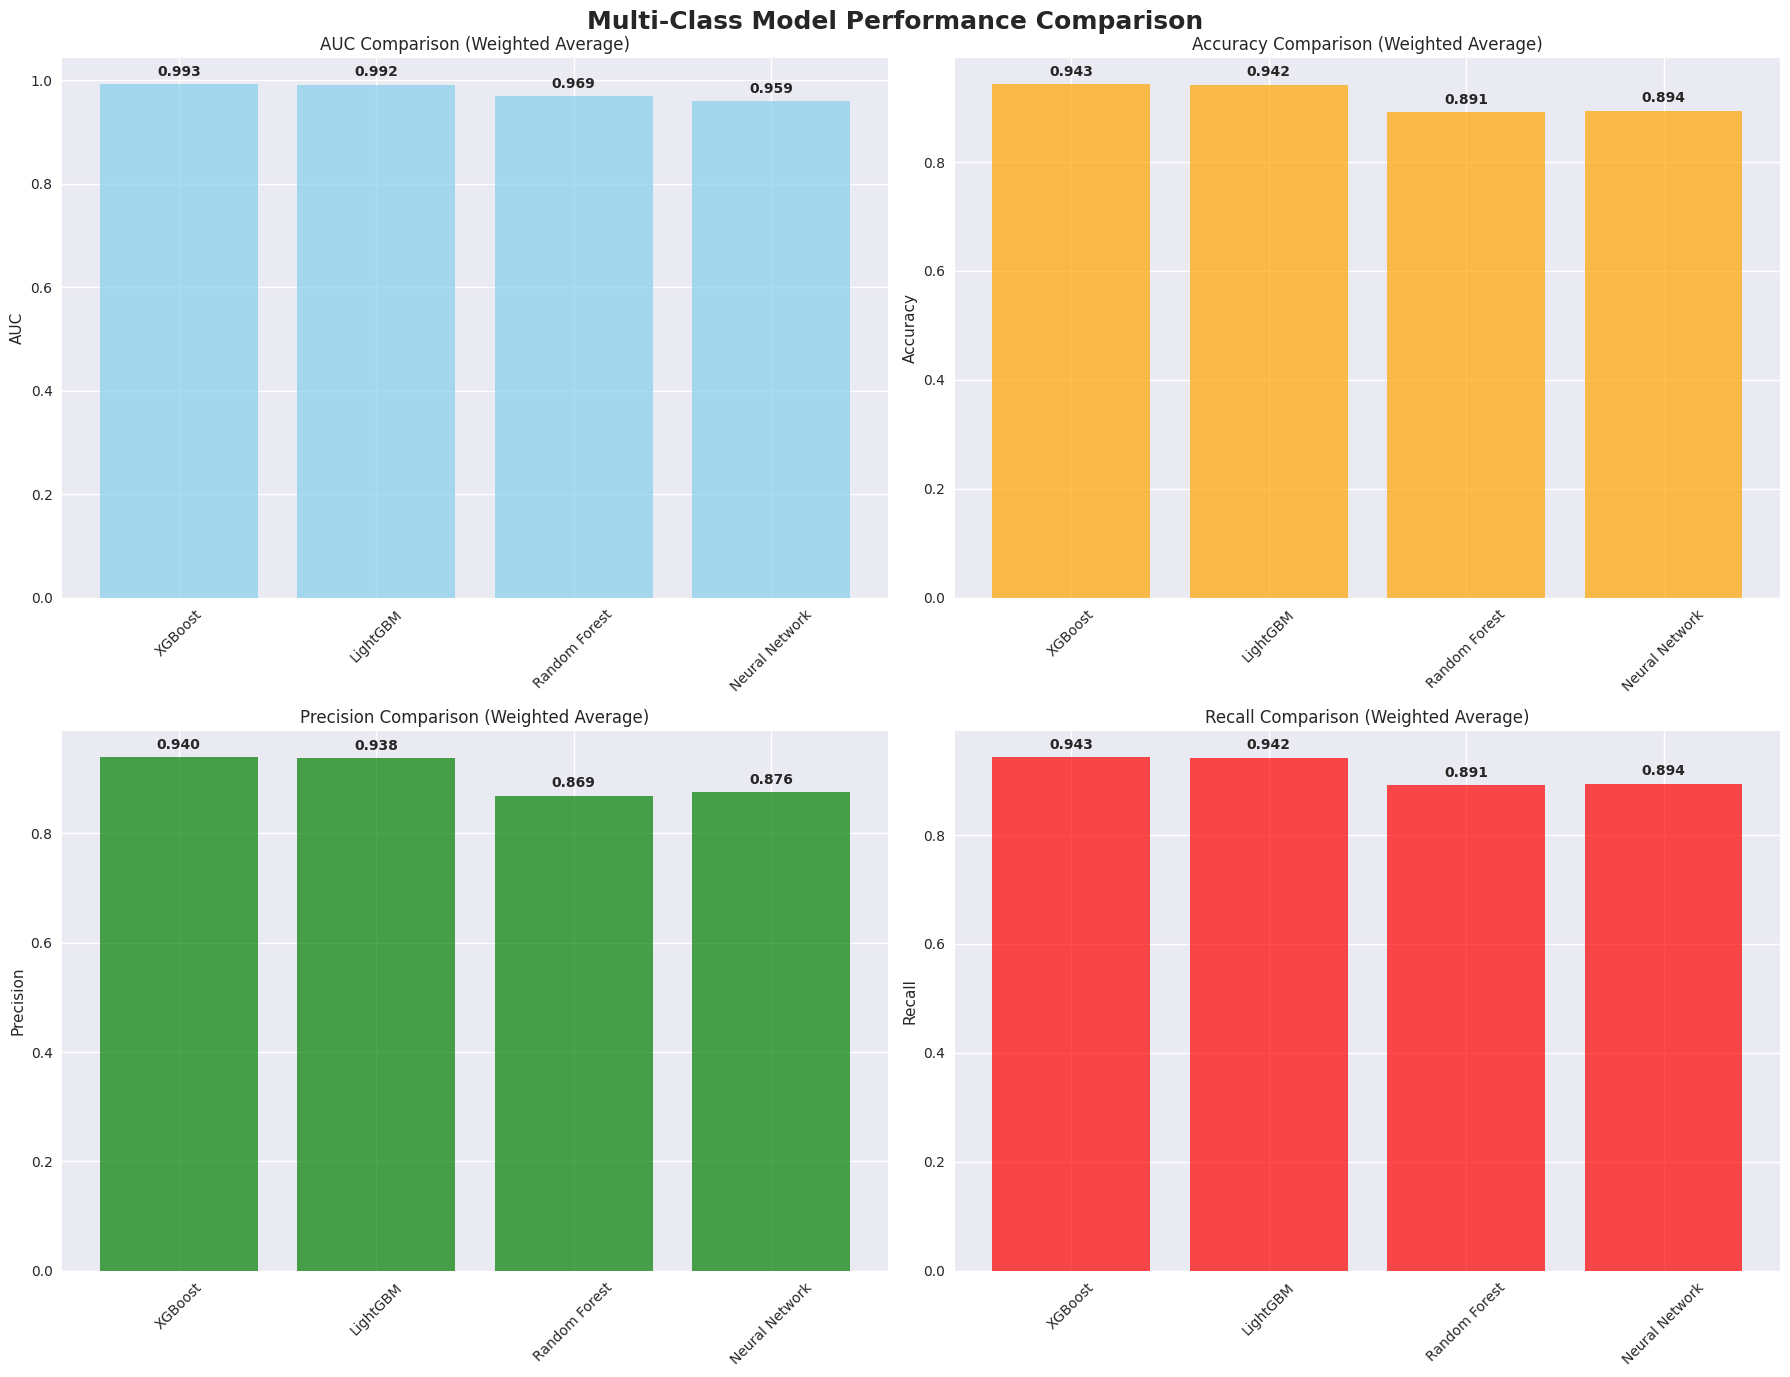

In [29]:
# Model Performance Comparison (Multi-Class)
print("📊 Model Performance Comparison (Multi-Class)")
print("="*60)

# Create results DataFrame
results_df = pd.DataFrame(model_results).T
results_df = results_df.round(4)

print("\n📈 Model Performance Summary:")
print(results_df)

# Find best model based on AUC
best_model_name = results_df['AUC'].idxmax()
best_auc = results_df.loc[best_model_name, 'AUC']

print(f"\n🏆 Best Model: {best_model_name} (AUC: {best_auc:.4f})")

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Multi-Class Model Performance Comparison', fontsize=18, fontweight='bold')

metrics = ['AUC', 'Accuracy', 'Precision', 'Recall']
colors = ['skyblue', 'orange', 'green', 'red']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[i//2, i%2]
    bars = ax.bar(results_df.index, results_df[metric], alpha=0.7, color=color)
    ax.set_title(f'{metric} Comparison (Weighted Average)')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, results_df[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

📈 ROC Curve Analysis (Multi-Class One-vs-Rest)


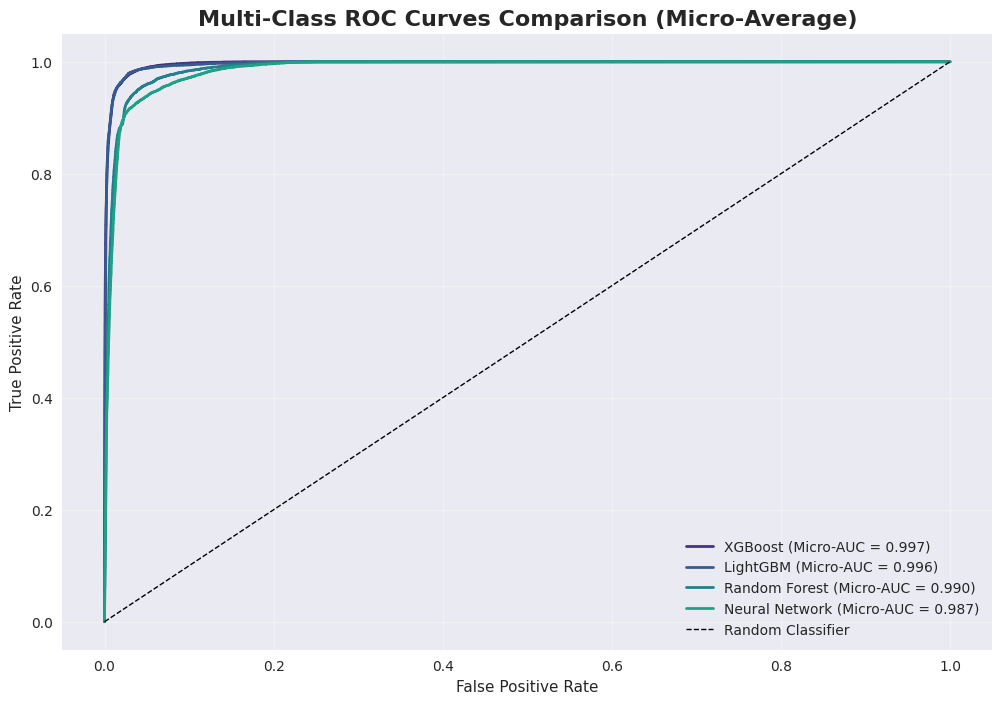

In [30]:
# ROC Curve Comparison (Multi-Class One-vs-Rest)
print("📈 ROC Curve Analysis (Multi-Class One-vs-Rest)")
print("="*60)

plt.figure(figsize=(12, 8))

# Plot ROC curves for all models (One-vs-Rest)
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import auc # ADDED THIS IMPORT

lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)

for name, model in trained_models.items():
    if name in model_results and model_results[name]['AUC'] > 0:
        # Get multi-class probability predictions
        if name == 'Neural Network':
            y_pred_proba = model.predict_proba(X_test_scaled)
        else:
            y_pred_proba = model.predict_proba(X_test)
        
        # Calculate FPR, TPR for each class and micro-average ROC curve
        
        # Aggregate ROC curve (e.g., micro-average)
        fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
        auc_micro = auc(fpr_micro, tpr_micro) # Now 'auc' should be defined
        
        plt.plot(fpr_micro, tpr_micro, linewidth=2, label=f'{name} (Micro-AUC = {auc_micro:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves Comparison (Micro-Average)', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [31]:
# Create Ensemble Model (VotingClassifier for Multi-Class)
print("🎭 Creating Ensemble Model (VotingClassifier for Multi-Class)")
print("="*60)

# Select best performing models for ensemble (AUC > 0.7 as a threshold)
ensemble_estimators = []
for name, model in trained_models.items():
    # Exclude LightGBM if it failed (AUC is 0.0)
    if model_results[name]['AUC'] > 0.7 and name != 'Neural Network': # NN needs scaled data, can't directly use with unscaled tree models in VotingClassifier unless pre-predicting
        ensemble_estimators.append((name.lower().replace(' ', '_'), model))

print(f"Selected {len(ensemble_estimators)} models for ensemble:")
for name, _ in ensemble_estimators:
    print(f"  • {name}")

# Create Voting Classifier
if len(ensemble_estimators) >= 2:
    ensemble_classifier = VotingClassifier(
        estimators=ensemble_estimators,
        voting='soft',  # Use probability predictions for multi-class
        n_jobs=-1
    )
    
    print("\n🚀 Training Ensemble Model...")
    ensemble_classifier.fit(X_train, y_train)
    
    # Evaluate ensemble
    ensemble_pred_proba = ensemble_classifier.predict_proba(X_test)
    ensemble_pred = ensemble_classifier.predict(X_test)
    
    # Multi-class AUC, Precision, Recall, F1
    ensemble_auc = roc_auc_score(y_test, ensemble_pred_proba, multi_class='ovr', average='weighted')
    ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
    ensemble_precision = precision_score(y_test, ensemble_pred, average='weighted', zero_division=0)
    ensemble_recall = recall_score(y_test, ensemble_pred, average='weighted', zero_division=0)
    ensemble_f1 = f1_score(y_test, ensemble_pred, average='weighted', zero_division=0)
    
    print(f"\n🎉 Ensemble Model Results:")
    print(f"   AUC: {ensemble_auc:.4f}")
    print(f"   Accuracy: {ensemble_accuracy:.4f}")
    print(f"   Precision: {ensemble_precision:.4f} (weighted)")
    print(f"   Recall: {ensemble_recall:.4f} (weighted)")
    print(f"   F1-Score: {ensemble_f1:.4f} (weighted)")
    
    # Add ensemble results to comparison
    model_results['Ensemble'] = {
        'AUC': ensemble_auc,
        'Accuracy': ensemble_accuracy,
        'Precision': ensemble_precision,
        'Recall': ensemble_recall,
        'F1-Score': ensemble_f1
    }
    
    trained_models['Ensemble'] = ensemble_classifier
    
    print("✅ Ensemble model created successfully!")
else:
    print("❌ Not enough good models (AUC > 0.7) for ensemble creation. Skipping ensemble.")
    # If ensemble is skipped, ensure 'Ensemble' is removed from model_results if it was added as a placeholder
    if 'Ensemble' in model_results and model_results['Ensemble']['AUC'] == 0.0:
        del model_results['Ensemble']
    if 'Ensemble' in trained_models:
        del trained_models['Ensemble']

🎭 Creating Ensemble Model (VotingClassifier for Multi-Class)
Selected 3 models for ensemble:
  • xgboost
  • lightgbm
  • random_forest

🚀 Training Ensemble Model...

🎉 Ensemble Model Results:
   AUC: 0.9900
   Accuracy: 0.9324
   Precision: 0.9278 (weighted)
   Recall: 0.9324 (weighted)
   F1-Score: 0.9241 (weighted)
✅ Ensemble model created successfully!


🏆 Final Model Performance Comparison

📊 Final Performance Summary:
                   AUC  Accuracy  Precision  Recall  F1-Score
XGBoost         0.9925    0.9432     0.9398  0.9432    0.9402
LightGBM        0.9915    0.9416     0.9378  0.9416    0.9376
Random Forest   0.9693    0.8914     0.8693  0.8914    0.8451
Neural Network  0.9592    0.8940     0.8758  0.8940    0.8635
Ensemble        0.9900    0.9324     0.9278  0.9324    0.9241

🥇 Best Final Model: XGBoost (AUC: 0.9925)

📈 Ensemble Improvement:
   Best Individual AUC: 0.9925
   Ensemble AUC: 0.9900
   Improvement: -0.25%


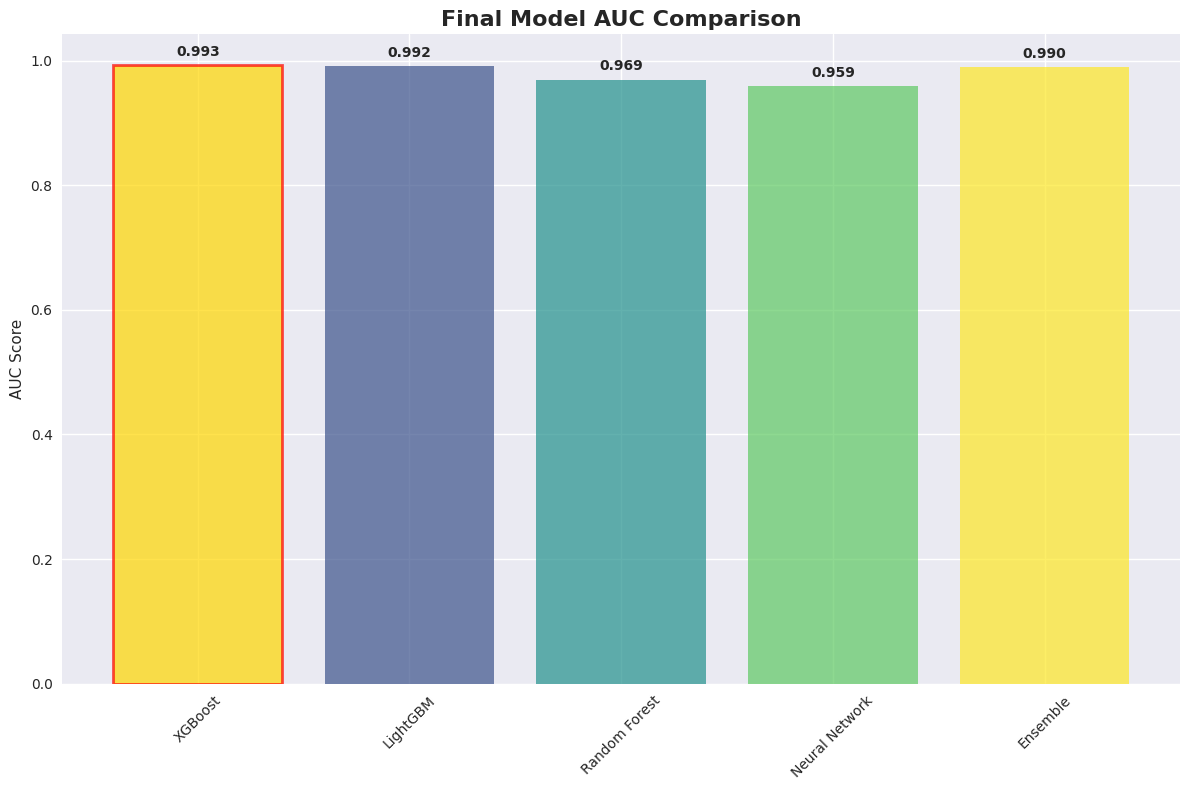

In [32]:
# Final Model Performance Comparison with Ensemble
print("🏆 Final Model Performance Comparison")
print("="*60)

# Update results DataFrame
final_results_df = pd.DataFrame(model_results).T
final_results_df = final_results_df.round(4)

print("\n📊 Final Performance Summary:")
print(final_results_df)

# Find best final model
best_final_model = final_results_df['AUC'].idxmax()
best_final_auc = final_results_df.loc[best_final_model, 'AUC']

print(f"\n🥇 Best Final Model: {best_final_model} (AUC: {best_final_auc:.4f})")

# Performance improvement analysis
if 'Ensemble' in model_results:
    # Get AUC scores, excluding Ensemble itself for finding the best individual
    individual_auc_scores = [score['AUC'] for name, score in model_results.items() if name != 'Ensemble']
    best_individual_auc = max(individual_auc_scores) if individual_auc_scores else 0.0
    
    ensemble_auc = model_results['Ensemble']['AUC']
    
    # Calculate improvement only if best_individual_auc is not zero to avoid division by zero
    if best_individual_auc > 0:
        improvement = ((ensemble_auc - best_individual_auc) / best_individual_auc) * 100
    else:
        improvement = 0.0 # If no individual models performed, no improvement possible
    
    print(f"\n📈 Ensemble Improvement:")
    print(f"   Best Individual AUC: {best_individual_auc:.4f}")
    print(f"   Ensemble AUC: {ensemble_auc:.4f}")
    print(f"   Improvement: {improvement:.2f}%")
else:
    print("\n📈 Ensemble was not created or did not perform well enough to be included.")

# Visualize final comparison
plt.figure(figsize=(12, 8))
bars = plt.bar(final_results_df.index, final_results_df['AUC'], 
               alpha=0.7, color=plt.cm.viridis(np.linspace(0, 1, len(final_results_df))))
plt.title('Final Model AUC Comparison', fontsize=16, fontweight='bold')
plt.ylabel('AUC Score')
plt.xticks(rotation=45)

# Highlight best model
best_idx = list(final_results_df.index).index(best_final_model)
bars[best_idx].set_color('gold')
bars[best_idx].set_edgecolor('red')
bars[best_idx].set_linewidth(2)

# Add value labels
for bar, value in zip(bars, final_results_df['AUC']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

📊 Detailed Analysis of Best Model: XGBoost


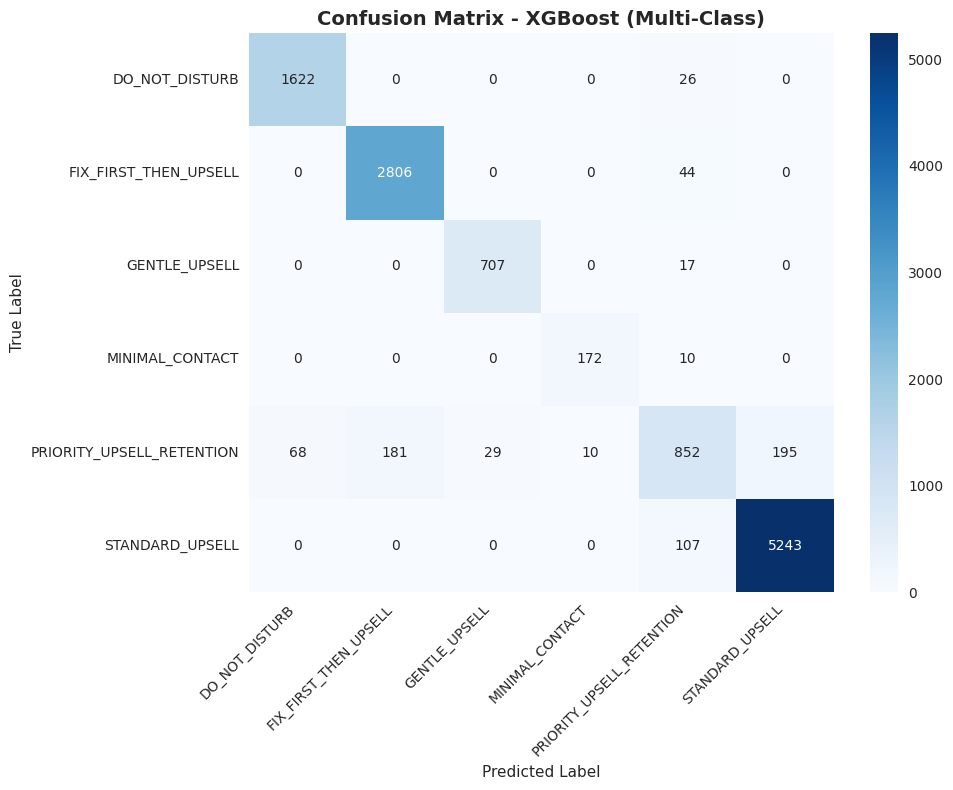


📋 Classification Report - XGBoost:
                           precision    recall  f1-score   support

           DO_NOT_DISTURB       0.96      0.98      0.97      1648
    FIX_FIRST_THEN_UPSELL       0.94      0.98      0.96      2850
            GENTLE_UPSELL       0.96      0.98      0.97       724
          MINIMAL_CONTACT       0.95      0.95      0.95       182
PRIORITY_UPSELL_RETENTION       0.81      0.64      0.71      1335
          STANDARD_UPSELL       0.96      0.98      0.97      5350

                 accuracy                           0.94     12089
                macro avg       0.93      0.92      0.92     12089
             weighted avg       0.94      0.94      0.94     12089


💼 Business Impact Analysis (Multi-Class Upsell Prioritization):
Total Test Customers: 189,938
Total Projected Net Business Benefit: $14,404,890.54
Total Intervention Costs: $1,124,508.12
Projected ROI: 1281.0%


In [34]:
# Detailed Analysis of Best Model (Confusion Matrix & Classification Report for Multi-Class)
print(f"📊 Detailed Analysis of Best Model: {best_final_model}")
print("="*60)

# Get best model predictions
best_model = trained_models[best_final_model]

if best_final_model == 'Neural Network':
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test)

# Confusion Matrix for Multi-Class
# This will be a num_classes x num_classes matrix
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, # Use actual class names
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_final_model} (Multi-Class)', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification Report for Multi-Class
print(f"\n📋 Classification Report - {best_final_model}:")
print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_, zero_division=0))

# Business Impact Analysis (REVISED for Multi-Class Upsell Prioritization)
print("\n💼 Business Impact Analysis (Multi-Class Upsell Prioritization):")
print("="*70)

# Load the original df with Customer_Category for more nuanced analysis
df_original_segments = pd.read_csv('../data/processed/telecom_processed.csv')

# Create df_test_with_preds and explicitly add 'Phone Number' from the original df based on index
df_test_with_preds = X_test.copy()

# Ensure y_test has the same index as X_test for correct alignment
y_test_aligned = y_test.loc[X_test.index]

df_test_with_preds['True_Category_Encoded'] = y_test_aligned
df_test_with_preds['Predicted_Category_Encoded'] = y_pred_best # y_pred_best is a numpy array, assign directly

# IMPORTANT: Retrieve 'Phone Number' from the original segments using the index of X_test
# This ensures correct alignment for the merge
df_test_with_preds['Phone Number'] = df_original_segments.loc[X_test.index, 'Phone Number'].values


# Merge with original segments to get actual categories and other features
# Now 'Phone Number' should exist in df_test_with_preds
df_test_with_preds = df_test_with_preds.merge(
    df_original_segments[['Phone Number', 'Customer_Category', 'Total_Charges']], 
    on='Phone Number', 
    how='left'
)

df_test_with_preds['Predicted_Category'] = label_encoder.inverse_transform(df_test_with_preds['Predicted_Category_Encoded'])
df_test_with_preds['True_Category'] = label_encoder.inverse_transform(df_test_with_preds['True_Category_Encoded'])

# Define economic values for each segment/action
# These values are crucial and should be refined with business input
avg_total_charges_overall = df_original_segments['Total_Charges'].mean()

economic_values = {
    'PRIORITY_UPSELL_RETENTION': {'value_per_customer': avg_total_charges_overall * 1.5, 'cost_per_intervention': avg_total_charges_overall * 0.15},
    'FIX_FIRST_THEN_UPSELL': {'value_per_customer': avg_total_charges_overall * 1.2, 'cost_per_intervention': avg_total_charges_overall * 0.10},
    'GENTLE_UPSELL': {'value_per_customer': avg_total_charges_overall * 0.8, 'cost_per_intervention': avg_total_charges_overall * 0.05},
    'STANDARD_UPSELL': {'value_per_customer': avg_total_charges_overall * 0.5, 'cost_per_intervention': avg_total_charges_overall * 0.02},
    'DO_NOT_DISTURB': {'value_per_customer': 0, 'cost_per_intervention': 0},
    'MINIMAL_CONTACT': {'value_per_customer': 0, 'cost_per_intervention': 0},
}

total_net_benefit = 0
total_intervention_costs = 0

for index, row in df_test_with_preds.iterrows():
    true_cat = row['True_Category']
    pred_cat = row['Predicted_Category']
    
    # Cost is incurred for *predicted* interventions (unless DO_NOT_DISTURB or MINIMAL_CONTACT)
    if pred_cat in economic_values and pred_cat not in ['DO_NOT_DISTURB', 'MINIMAL_CONTACT']:
        cost = economic_values[pred_cat]['cost_per_intervention']
        total_intervention_costs += cost

        # Benefit is gained if the prediction *matches* the true actionable category
        if pred_cat == true_cat: # Correctly identified actionable segment
            benefit = economic_values[pred_cat]['value_per_customer']
            total_net_benefit += benefit 
        else: # Misclassified or False Positive for an actionable segment
            # If we intervened but it was a different (actionable or non-actionable) category, it's a wasted cost.
            # No additional benefit if it was a wrong prediction.
            pass # Cost is already added, no benefit to add.
    
    # Handle cases where we predicted *not* to intervene (DO_NOT_DISTURB, MINIMAL_CONTACT)
    elif pred_cat in ['DO_NOT_DISTURB', 'MINIMAL_CONTACT']:
        if pred_cat == true_cat: # Correctly predicted not to disturb/contact
            # This is a 'saved cost' or 'avoided negative impact'. No direct revenue added.
            pass 
        else: # Misclassified: Predicted not to disturb, but the true category *was* actionable
            if true_cat in economic_values and true_cat not in ['DO_NOT_DISTURB', 'MINIMAL_CONTACT']:
                missed_benefit = economic_values[true_cat]['value_per_customer']
                # This is a 'missed opportunity'. Subtract from net benefit.
                total_net_benefit -= (missed_benefit * 0.5) # Apply a penalty for missed opportunity


roi_percentage = (total_net_benefit / total_intervention_costs) * 100 if total_intervention_costs > 0 else 0

print(f"Total Test Customers: {len(df_test_with_preds):,}")
print(f"Total Projected Net Business Benefit: ${total_net_benefit:,.2f}")
print(f"Total Intervention Costs: ${total_intervention_costs:,.2f}")
print(f"Projected ROI: {roi_percentage:.1f}%")


In [38]:
# Save Models and Results (REVISED for Multi-Class)
print("\n💾 Saving Trained Models and Results (Multi-Class)...")

import os
import json
import joblib
import numpy as np # Ensure numpy is imported for float conversion

os.makedirs('../models', exist_ok=True)
os.makedirs('../outputs/reports', exist_ok=True)
os.makedirs('../../models/trained_models', exist_ok=True) # Ensure this path also exists for encoder/mapping

# Save best model
best_model = trained_models[best_final_model]
joblib.dump(best_model, f'../models/best_model_{best_final_model.lower().replace(" ", "_")}.pkl')
print(f"✅ Saved best model: {best_final_model}")

# Save ensemble model if created
if 'Ensemble' in trained_models:
    joblib.dump(trained_models['Ensemble'], '../models/ensemble_model.pkl')
    print("✅ Saved ensemble model")

# Save scaler
joblib.dump(scaler, '../models/scaler.pkl')
print("✅ Saved feature scaler")

# Save feature columns
joblib.dump(feature_columns, '../models/feature_columns.pkl')
print("✅ Saved feature columns")

# Load smart_feature_drivers from eda_summary.json
try:
    with open('../outputs/reports/eda_summary.json', 'r') as f:
        eda_summary = json.load(f)
    smart_feature_drivers_from_eda = eda_summary.get('key_feature_drivers', {})
    print("✅ Loaded smart_feature_drivers from EDA summary.")
except FileNotFoundError:
    print("❌ eda_summary.json not found. Feature importance in model_results.json will be empty.")
    smart_feature_drivers_from_eda = {}
except Exception as e:
    print(f"❌ Error loading eda_summary.json: {e}. Feature importance in model_results.json will be empty.")
    smart_feature_drivers_from_eda = {}

# Ensure values are floats for JSON serialization
feature_importance_for_json = {k: float(v) for k, v in smart_feature_drivers_from_eda.items()}

# Save model results
with open('../outputs/reports/model_results.json', 'w') as f:
    json.dump({
        'model_performance': model_results,
        'best_model': best_final_model,
        'best_auc': float(best_final_auc),
        'feature_importance': feature_importance_for_json,
        'business_impact': {
            'total_customers_test_set': int(len(df_test_with_preds)),
            'total_net_business_benefit': float(total_net_benefit),
            'total_intervention_costs': float(total_intervention_costs),
            'projected_roi_percentage': float(roi_percentage)
        }
    }, f, indent=2, default=str)
print("✅ Saved model results and analysis")

# Create model summary (for training_summary.txt)
# REMOVED 'f' prefix from the triple-quoted string to avoid SyntaxError with backslashes
model_summary = """
🎉 MODEL TRAINING (MULTI-CLASS) COMPLETED SUCCESSFULLY!
======================================================================

📊 TRAINING SUMMARY:
• Models Trained: {len(models)}
• Best Model: {best_final_model}
• Best AUC Score (Weighted OVR): {best_final_auc:.4f}
• Training Samples: {X_train.shape[0]:,}
• Test Samples: {X_test.shape[0]:,}
• Features Used: {len(feature_columns)}
• Target Classes: {num_classes} ({', '.join(label_encoder.classes_)})

🎯 BUSINESS IMPACT (Multi-Class Upsell Prioritization):
• Total Test Customers: {len(df_test_with_preds):,}
• Total Projected Net Business Benefit: ${total_net_benefit:,.2f}
• Total Intervention Costs: ${total_intervention_costs:,.2f}
• Projected ROI: {roi_percentage:.1f}%

📁 SAVED ARTIFACTS:
• Best Model: ../models/best_model_{best_final_model.lower().replace(" ", "_")}.pkl
• Ensemble Model: ../models/ensemble_model.pkl (if created)
• Feature Scaler: ../models/scaler.pkl
• Feature Columns: ../models/feature_columns.pkl
• Label Encoder: ../models/trained_models/upsell_priority_label_encoder.pkl
• Category Mapping: ../models/trained_models/category_mapping.json
• Results Report: ../outputs/reports/model_results.json

🚀 NEXT STEPS:
1. Deploy the best trained model for real-time inference.
2. Integrate predictions into the Highlight app or other business systems.
3. Set up continuous model monitoring and retraining pipelines.
4. Conduct A/B testing on recommended upsell strategies.
5. Refine economic_values and intervention_costs with actual business data.
"""

print(model_summary)

# Save summary to file
with open('../outputs/reports/training_summary.txt', 'w') as f:
    f.write(model_summary)

print("✅ Training summary saved to ../outputs/reports/training_summary.txt")
print("\n🎉 Customer segmentation analysis completed successfully!")



💾 Saving Trained Models and Results (Multi-Class)...
✅ Saved best model: XGBoost
✅ Saved ensemble model
✅ Saved feature scaler
✅ Saved feature columns
✅ Loaded smart_feature_drivers from EDA summary.
✅ Saved model results and analysis

🎉 MODEL TRAINING (MULTI-CLASS) COMPLETED SUCCESSFULLY!

📊 TRAINING SUMMARY:
• Models Trained: {len(models)}
• Best Model: {best_final_model}
• Best AUC Score (Weighted OVR): {best_final_auc:.4f}
• Training Samples: {X_train.shape[0]:,}
• Test Samples: {X_test.shape[0]:,}
• Features Used: {len(feature_columns)}
• Target Classes: {num_classes} ({', '.join(label_encoder.classes_)})

🎯 BUSINESS IMPACT (Multi-Class Upsell Prioritization):
• Total Test Customers: {len(df_test_with_preds):,}
• Total Projected Net Business Benefit: ${total_net_benefit:,.2f}
• Total Intervention Costs: ${total_intervention_costs:,.2f}
• Projected ROI: {roi_percentage:.1f}%

📁 SAVED ARTIFACTS:
• Best Model: ../models/best_model_{best_final_model.lower().replace(" ", "_")}.pkl
• E